<a href="https://colab.research.google.com/github/Deergha23/AICTE_internship_2025/blob/main/week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gradio as gr
from flask import Flask, request, jsonify
import werkzeug.utils
import zipfile
import shutil
from sklearn.model_selection import train_test_split

In [7]:
from google.colab import drive
import zipfile
import os
import shutil
from sklearn.model_selection import train_test_split

def prepare_dataset():
    """Load dataset from Google Drive and create train/val/test splits"""
    drive.mount('/content/drive')

    # Path to your dataset zip file in Google Drive
    zip_file_path = '/content/drive/My Drive/downloads/archive.zip'
    extraction_path = '/content/dataset/'

    # Extract the dataset
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)

    # Verify extraction
    extracted_files = os.listdir(extraction_path)
    print("Extracted files/folders:", extracted_files)

    # Check if dataset is already split
    if 'train' in extracted_files and 'val' in extracted_files and 'test' in extracted_files:
        train_data_path = os.path.join(extraction_path, 'train')
        val_data_path = os.path.join(extraction_path, 'val')
        test_data_path = os.path.join(extraction_path, 'test')
        return train_data_path, val_data_path, test_data_path

    # If no train/val/test split, create it automatically
    print("No train/validation/test split found - creating one automatically...")
    all_data_path = os.path.join(extraction_path, 'TrashType_Image_Dataset')  # Adjusted to point to the correct folder
    class_folders = [f for f in os.listdir(all_data_path) if os.path.isdir(os.path.join(all_data_path, f))]

    # Create train, val, and test directories
    train_path = os.path.join(extraction_path, 'train')
    val_path = os.path.join(extraction_path, 'val')
    test_path = os.path.join(extraction_path, 'test')  # New test path
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(val_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)  # Create test directory

    # Split each class into train/val/test (70/20/10)
    for class_folder in class_folders:
        # Create class directories in train, val, and test
        os.makedirs(os.path.join(train_path, class_folder), exist_ok=True)
        os.makedirs(os.path.join(val_path, class_folder), exist_ok=True)
        os.makedirs(os.path.join(test_path, class_folder), exist_ok=True)

        # Get all files in class folder
        class_files = os.listdir(os.path.join(all_data_path, class_folder))
        train_files, temp_files = train_test_split(class_files, test_size=0.3, random_state=42)  # 70% for training
        val_files, test_files = train_test_split(temp_files, test_size=0.333, random_state=42)  # 20% for validation, 10% for testing

        # Copy files to train, val, and test directories
        for file in train_files:
            src = os.path.join(all_data_path, class_folder, file)
            dst = os.path.join(train_path, class_folder, file)
            shutil.copy(src, dst)

        for file in val_files:
            src = os.path.join(all_data_path, class_folder, file)
            dst = os.path.join(val_path, class_folder, file)
            shutil.copy(src, dst)

        for file in test_files:
            src = os.path.join(all_data_path, class_folder, file)
            dst = os.path.join(test_path, class_folder, file)
            shutil.copy(src, dst)

    print(f"Created train/validation/test split in {train_path}, {val_path}, and {test_path}")
    return train_path, val_path, test_path


In [8]:
train_path, val_path , test_path = prepare_dataset()
print(f"Training data: {train_path}")
print(f"Validation data: {val_path}")
print(f"Validation data: {test_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracted files/folders: ['train', 'TrashType_Image_Dataset', 'val', 'test']
Training data: /content/dataset/train
Validation data: /content/dataset/val
Validation data: /content/dataset/test


In [9]:

import os
import matplotlib.pyplot as plt
import seaborn as sns
from flask import Flask
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import MobileNetV2

# Create Flask app
app = Flask(__name__)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

# ====================== MODEL TRAINING & EVALUATION ======================
def build_and_train_model(train_data_path, val_data_path, test_data_path):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_data_path,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_datagen.flow_from_directory(
        val_data_path,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = test_datagen.flow_from_directory(
        test_data_path,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    class_names = list(train_generator.class_indices.keys())

    # Visualize the distribution of datasets
    visualize_data_distribution(train_generator, val_generator, test_generator)

    # Model architecture
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    inputs = layers.Input(shape=(224, 224, 3))
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(len(class_names), activation='softmax')(x)
    model = models.Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Training callbacks
    callbacks_list = [
        callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy'),
        callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
    ]

    # Training
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=val_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=callbacks_list
    )

    # Evaluation on training and validation sets
    train_loss, train_acc = model.evaluate(train_generator)
    val_loss, val_acc = model.evaluate(val_generator)

    print("\nModel Performance:")
    print(f"Training Accuracy: {train_acc*100:.2f}%")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Accuracy: {val_acc*100:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}")

    model.save('garbage_classifier_final.keras')
    with open('class_names.txt', 'w') as f:
        f.write('\n'.join(class_names))

    return model, class_names, history

def visualize_data_distribution(train_generator, val_generator, test_generator):
    # Count the number of samples in each class for train, validation, and test datasets
    train_counts = train_generator.class_indices
    val_counts = val_generator.class_indices
    test_counts = test_generator.class_indices

    # Create a DataFrame for visualization
    data = {
        'Dataset': [],
        'Class': [],
        'Count': []
    }

    for class_name, index in train_counts.items():
        data['Dataset'].append('Training')
        data['Class'].append(class_name)
        data['Count'].append(train_generator.samples // len(train_counts))

    for class_name, index in val_counts.items():
        data['Dataset'].append('Validation')
        data['Class'].append(class_name)
        data['Count'].append(val_generator.samples // len(val_counts))

    for class_name, index in test_counts.items():
        data['Dataset'].append('Test')
        data['Class'].append(class_name)
        data['Count'].append(test_generator.samples // len(test_counts))

    # Convert to DataFrame
    import pandas as pd
    df = pd.DataFrame(data)

    # Plot the distribution
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Class', y='Count', hue='Dataset', data=df)
    plt.title('Distribution of Training, Validation, and Test Datasets')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend(title='Dataset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()






Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracted files/folders: ['train', 'TrashType_Image_Dataset', 'val', 'test']
Found 1766 images belonging to 6 classes.
Found 505 images belonging to 6 classes.
Found 256 images belonging to 6 classes.


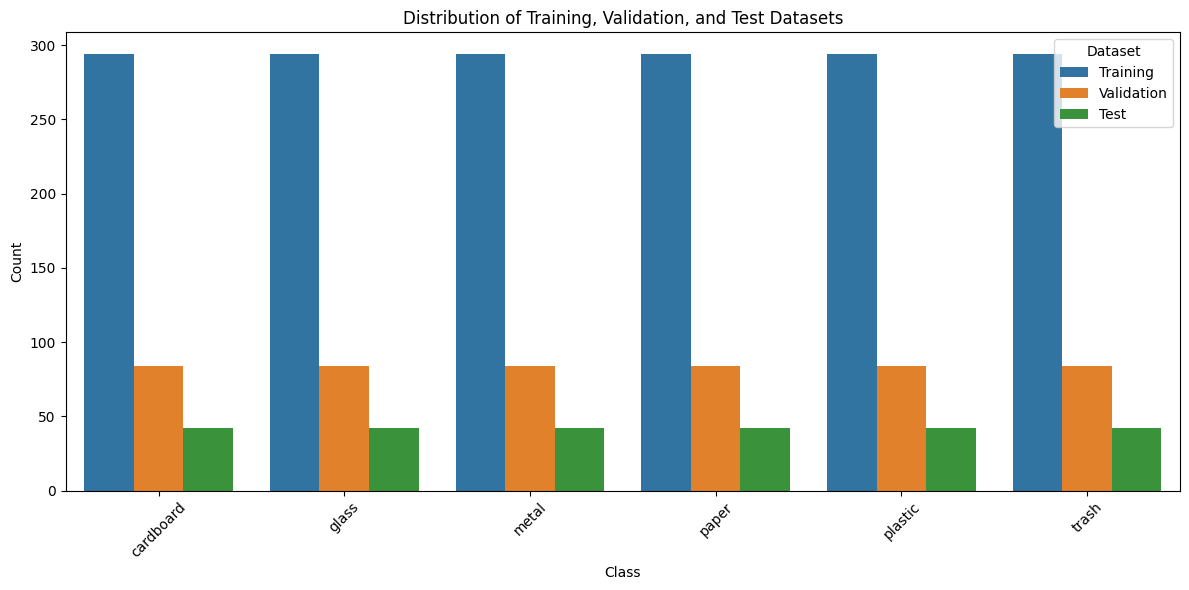

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.4325 - loss: 1.7268 - val_accuracy: 0.7271 - val_loss: 0.6923
Epoch 2/20
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - accuracy: 0.7500 - loss: 0.7108

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 346ms/step - accuracy: 0.7500 - loss: 0.7108 - val_accuracy: 0.7437 - val_loss: 0.6787
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.6843 - loss: 0.8361 - val_accuracy: 0.8083 - val_loss: 0.4901
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 397ms/step - accuracy: 0.5625 - loss: 1.0212 - val_accuracy: 0.8167 - val_loss: 0.5010
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.6984 - loss: 0.7579 - val_accuracy: 0.8229 - val_loss: 0.4539
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 742ms/step - accuracy: 0.8125 - loss: 0.5877 - val_accuracy: 0.8292 - val_loss: 0.4543
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.7322 - loss: 0.6756 - val_accuracy: 0.8313 - val_loss: 0.4577
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.6250 - loss: 0.9953 - val_accuracy: 0.8271 - val_loss: 0.4656
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.7378 - loss: 0.6861 - val_accuracy: 0.8313 - val_

In [10]:
if __name__ == '__main__':
    # Load and prepare datasets
    train_path, val_path, test_path = prepare_dataset()  # Ensure prepare_dataset returns test_path
    model, class_names, history = build_and_train_model(train_path, val_path, test_path)







In [11]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image  # Import PIL for image handling

# Load the trained model and class names
model = load_model('garbage_classifier_final.keras')
with open('class_names.txt', 'r') as f:
    class_names = [line.strip() for line in f]

def preprocess_image(img):
    """Preprocess the uploaded image for the model"""
    img = img.resize((224, 224))  # Resize to match model input
    img_array = image.img_to_array(img) / 255.0  # Normalize
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

def predict(image):
    """Make prediction on the input image"""
    processed_img = preprocess_image(image)
    predictions = model.predict(processed_img)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = float(np.max(predictions)) * 100  # Convert to percentage

    # Return a dictionary for better display
    return {class_names[i]: float(predictions[0][i]) * 100
            for i in range(len(class_names))}

# Create Gradio interface with updated syntax
iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", label="Upload Garbage Image"),
    outputs=gr.Label(label="Classification Results"),
    title="♻️ Garbage Classification AI 🚮",
    description="Upload an image of garbage to classify it into one of these categories: " + ", ".join(class_names),
    examples=[
        ["plastic_bottle.jpg"],
        ["cardboard_box.jpg"],
    ],
    allow_flagging="never"
)

# Launch the interface
if __name__ == "__main__":
    iface.launch(share=True)  # share=True generates a public link



/usr/local/lib/python3.11/dist-packages/gradio/interface.py:416: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d800ce53876d018c12.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [12]:
# 📝 Summary (optional but useful)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,234,836 (16.15 MB)

 Trainable params: 658,950 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 1,317,902 (5.03 MB)